<a href="https://colab.research.google.com/github/royseto/langgraph-tutorials-royseto/blob/main/Refactored_LangGraph_Quickstart_part_2_using_prebuilts_royseto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This colab notebook has Roy's work with the LangGraph Quickstart at https://langchain-ai.github.io/langgraph/tutorials/introduction/

It starts with part 2, and pulls forward the refactoring from part 3 to use prebuilt funtions and classes for tool use.

# Setup

In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_anthropic

In [2]:
import os
from google.colab import userdata

os.environ["ANTHROPIC_API_KEY"] = userdata.get('ANTHROPIC_API_KEY')
os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langgraph-quickstart"

For Tavily hello world notebook, see https://colab.research.google.com/drive/1P16Y23P-1uSGLkQI50y0IUc3FdYgBGTW

"Tavily Search API is a search engine optimized for LLMs, aimed at efficient, quick and persistent search results." - https://docs.tavily.com/docs/welcome

In [3]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [4]:
import os
from google.colab import userdata
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [5]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [6]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [7]:
graph = graph_builder.compile(checkpointer=memory)

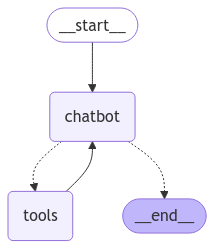

In [8]:
graph

In [9]:
config = {"configurable": {"thread_id": "1"}}

In [10]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to know or discuss?


In [11]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Of course, I remember your name, Will. Is there anything in particular you'd like to talk about or any questions you have? I'm here to help with a wide range of topics, so feel free to ask about anything you're curious about.


In [12]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='c3497e2c-63ab-446e-892c-36134bb514fc'), AIMessage(content="Hello Will! It's nice to meet you. How can I assist you today? Is there anything specific you'd like to know or discuss?", additional_kwargs={}, response_metadata={'id': 'msg_01NP4JVC7E1rtCBG7LepEutL', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 405, 'output_tokens': 32}}, id='run-82314213-04f7-481b-a291-c4618aae797c-0', usage_metadata={'input_tokens': 405, 'output_tokens': 32, 'total_tokens': 437, 'input_token_details': {'cache_creation': 0, 'cache_read': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='d19a8f3d-a80d-4611-9dd6-be258d5199e3'), AIMessage(content="Of course, I remember your name, Will. Is there anything

In [13]:
user_input = "tell me about stargate as announced in january, 2025"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

tell me about stargate as announced in january, 2025
================================== Ai Message ==================================

[{'text': "I apologize, but I need to correct a misunderstanding in your request. As an AI language model, I don't have real-time information about future events. We are currently in 2023, and I don't have information about announcements that might happen in January 2025. \n\nHowever, I can search for the most recent and relevant information about Stargate for you. Let me do that now.", 'type': 'text'}, {'id': 'toolu_01KmC2Nv3Nys7m1QdbKVeE8y', 'input': {'query': 'Stargate recent announcements or developments'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01KmC2Nv3Nys7m1QdbKVeE8y)
 Call ID: toolu_01KmC2Nv3Nys7m1QdbKVeE8y
  Args:
    query: Stargate recent announcements or developments
===========================

In [14]:
user_input = "tell me about stargate ai as announced on january 21, 2025"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

tell me about stargate ai as announced on january 21, 2025
================================== Ai Message ==================================

[{'text': "I understand you're asking about Stargate AI as announced on January 21, 2025. Since this is a future event from our current perspective, I'll need to search for the most up-to-date information available about this announcement. Let me do that for you.", 'type': 'text'}, {'id': 'toolu_01Wo57oVRT1vdqmaSPser2Nm', 'input': {'query': 'Stargate AI announcement January 21, 2025 Trump'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01Wo57oVRT1vdqmaSPser2Nm)
 Call ID: toolu_01Wo57oVRT1vdqmaSPser2Nm
  Args:
    query: Stargate AI announcement January 21, 2025 Trump
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.jdsu